In [1]:
%reload_ext autoreload
%autoreload 2


%matplotlib inline

# Amazon SageMaker

In [42]:
import base64
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Boilerplate

### Session

In [2]:
import boto3, time, json

sess = boto3.Session()
sm = sess.client("sagemaker")
region = sess.region_name
account = boto3.client("sts").get_caller_identity().get("Account")

### IAM Role

**Note**: make sure the IAM role has:  
- `AmazonS3FullAccess`  
- `AmazonEC2ContainerRegistryFullAccess`  
- `AmazonSageMakerFullAccess`  

In [3]:
import sagemaker

role = sagemaker.get_execution_role()
role

'arn:aws:iam::571744842822:role/EC2_S3_Busclip'

### Amazon Elastic Container Registry (ECR)

**Note**: create ECR if it doesn't exist

In [4]:
registry_name = "fastai-torchserve-sagemaker"
# !aws ecr create-repository --repository-name {registry_name}

{
    "repository": {
        "repositoryArn": "arn:aws:ecr:ap-southeast-2:571744842822:repository/fastai-torchserve-sagemaker",
        "registryId": "571744842822",
        "repositoryName": "fastai-torchserve-sagemaker",
        "repositoryUri": "571744842822.dkr.ecr.ap-southeast-2.amazonaws.com/fastai-torchserve-sagemaker",
        "createdAt": "2020-10-22T03:36:32+00:00",
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        }
    }
}


In [5]:
image = f"{account}.dkr.ecr.{region}.amazonaws.com/{registry_name}:latest"
image

'571744842822.dkr.ecr.ap-southeast-2.amazonaws.com/fastai-torchserve-sagemaker:latest'

### Pytorch Model Artifact

Create a compressed `*.tar.gz` file from the `*.mar` file per requirement of Amazon SageMaker and upload the model to your Amazon S3 bucket.

In [7]:
model_file_name = "fastunet"
s3_bucket_name = "deskchips2020"
# !tar cvzf {model_file_name}.tar.gz fastunet.mar
# !aws s3 cp {model_file_name}.tar.gz s3://{s3_bucket_name}/

tar: Removing leading `../' from member names
../model_store/fastunet.mar
upload: ./fastunet.tar.gz to s3://deskchips2020/fastunet.tar.gz   


### Build a FastAI+TorchServe Docker container and push it to Amazon ECR

In [13]:
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account}.dkr.ecr.{region}.amazonaws.com
!docker build -t {registry_name} ../
!docker tag {registry_name}:latest {image}
!docker push {image}

WARNING! Your password will be stored unencrypted in /home/ubuntu/snap/docker/471/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  5.251GB
Step 1/18 : FROM pytorch/pytorch
 ---> 6a2d656bcf94
Step 2/18 : ENV PYTHONUNBUFFERED TRUE
 ---> Using cache
 ---> 4d790acbf108
Step 3/18 : RUN apt-get update && apt-get install -y software-properties-common rsync
 ---> Using cache
 ---> 556f25f6b7fd
Step 4/18 : RUN add-apt-repository -y ppa:git-core/ppa && apt-get update && apt-get install -y git libglib2.0-dev graphviz && apt-get update
 ---> Using cache
 ---> 3dbdcce941cc
Step 5/18 : RUN pip install albumentations     catalyst     captum     "fastprogress>=0.1.22"     graphviz     kornia     matplotlib     "nbconvert<6"    neptune-cli     opencv-python     pandas     pillow     pyarrow     pydicom     pyyaml     scikit-learn     scikit

aa0161d: Pushing  716.2MB/1.064GBPushing  300.5MB/1.064GBPushing  3.761MB/63.22MBPushing  222.2MB/3.366GBPushing  550.2MBPushing  711.8MB/1.064GB

2b376448: Pushing  2.758GB/3.366GBPushing  749.7MB/1.064GB

2b376448: Pushed   3.396GB/3.366GBlatest: digest: sha256:2f57d1356564f93c9a327b60fdf758599576e1b5cac2b478772cf541beabe3f0 size: 4310


### Model

In [15]:
model_data = f"s3://{s3_bucket_name}/{model_file_name}.tar.gz"
sm_model_name = "fastai-unet-torchserve-sagemaker"

container = {"Image": image, "ModelDataUrl": model_data}

create_model_response = sm.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:ap-southeast-2:571744842822:model/fastai-unet-torchserve-sagemaker


## Batch Transform

### S3 Input and Output

In [16]:
batch_input = f"s3://{s3_bucket_name}/batch_transform_fastai_torchserve_sagemaker/"
batch_output = f"s3://{s3_bucket_name}/batch_transform_fastai_torchserve_sagemaker_output/"

In [17]:
!aws s3 ls {batch_input}

2020-10-22 03:48:28          0 
2020-10-22 03:49:19      21725 Seq05VD_f00210.png


In [28]:
import time

batch_job_name = 'chipstack-batch' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_job_name

'chipstack-batch2020-10-22-04-15-58'

### Batch transform jobs

In [29]:
request = {
    "ModelClientConfig": {
        "InvocationsTimeoutInSeconds": 3600,
        "InvocationsMaxRetries": 1,
    },
    "TransformJobName": batch_job_name,
    "ModelName": sm_model_name,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {"S3OutputPath": batch_output, "AssembleWith": "Line"},
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}
        },
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.p2.xlarge", "InstanceCount": 1},
}

In [30]:
%%time
sm.create_transform_job(**request)

while True:
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    print("Transform job is still in status: " + status)
    time.sleep(30)

Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
CPU times: user 259 ms, sys: 0 ns, total: 259 ms
Wall time: 9min 1s


### Testing

In [31]:
s3 = boto3.resource("s3")
s3.Bucket(f"{s3_bucket_name}").download_file(
    "batch_transform_fastai_torchserve_sagemaker_output/Seq05VD_f00210.png.out",
    "Seq05VD_f00210.txt",
)
s3.Bucket(f"{s3_bucket_name}").download_file(
    "batch_transform_fastai_torchserve_sagemaker/Seq05VD_f00210.png",
    "Seq05VD_f00210.png",
)

In [33]:
with open("Seq05VD_f00210.txt") as f:
    results = f.read()

response = json.loads(results)

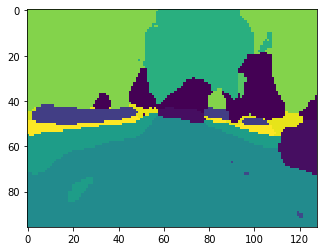

In [37]:
pred_decoded_byte = base64.decodebytes(bytes(response["base64_prediction"], encoding="utf-8"))
pred_decoded = np.reshape(
    np.frombuffer(pred_decoded_byte, dtype=np.uint8), (96, 128)
)
plt.imshow(pred_decoded);

## Inference Endpoint

### Endpoint configuration

**Note**: choose your preferred `InstanceType`: https://aws.amazon.com/sagemaker/pricing/

In [38]:
import time

endpoint_config_name = "torchserve-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

torchserve-endpoint-config-2020-10-22-04-31-10
Endpoint Config Arn: arn:aws:sagemaker:ap-southeast-2:571744842822:endpoint-config/torchserve-endpoint-config-2020-10-22-04-31-10


### Endpoint

In [39]:
endpoint_name = "torchserve-endpoint-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_name)

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

torchserve-endpoint-2020-10-22-04-31-21
arn:aws:sagemaker:ap-southeast-2:571744842822:endpoint/torchserve-endpoint-2020-10-22-04-31-21


In [40]:
%%time
resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:ap-southeast-2:571744842822:endpoint/torchserve-endpoint-2020-10-22-04-31-21
Status: InService
CPU times: user 122 ms, sys: 2.34 ms, total: 124 ms
Wall time: 8min 1s


### Testing

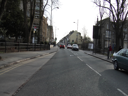

In [43]:
file_name = "../sample/Seq05VD_f00210.png"

with open(file_name, 'rb') as f:
    payload = f.read()
    
Image.open(file_name)

In [46]:
%%time
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)
response = json.loads(response["Body"].read())

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 103 ms


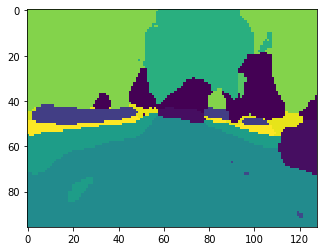

In [47]:
pred_decoded_byte = base64.decodebytes(bytes(response["base64_prediction"], encoding="utf-8"))
pred_decoded = np.reshape(
    np.frombuffer(pred_decoded_byte, dtype=np.uint8), (96, 128)
)
plt.imshow(pred_decoded);

### Cleanup

In [48]:
client = boto3.client("sagemaker")
client.delete_model(ModelName=sm_model_name)
client.delete_endpoint(EndpointName=endpoint_name)
client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': 'facf90cc-1843-448f-8f46-a717ad1301e6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'facf90cc-1843-448f-8f46-a717ad1301e6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 22 Oct 2020 04:40:38 GMT'},
  'RetryAttempts': 0}}